In [1]:
import numpy as np
import os
import time
from resnet50 import ResNet50
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten

from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

/home/tenzin/ML/env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/tenzin/ML/env/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
IMAGE_SIZE = 224

## Loading the training data & Preprocessing

In [3]:
# Loading the training data
PATH = os.getcwd()

# Define data path
data_path = PATH + '/Gaze_UPMC_Food20/images'
data_dir_list = os.listdir(data_path)[:5] # 5 classes

img_data_list=[]

for dataset in sorted(data_dir_list):
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        img_path = data_path + '/'+ dataset + '/'+ img 
        img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        # print('Input image shape:', x.shape)
        img_data_list.append(x)

Loaded the images of dataset-apple-pie

Loaded the images of dataset-chocolate-cake

Loaded the images of dataset-donuts

Loaded the images of dataset-french-toast

Loaded the images of dataset-gnocchi



In [4]:
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
print(img_data.shape)

(500, 224, 224, 3)


In [5]:
# Define the number of classes
num_classes = 5
num_of_samples = (img_data.shape[0])
labels = np.ones((num_of_samples,), dtype='int64')

labels[:101]=0
labels[101:201]=1
labels[201:301]=2
labels[301:401]=3
labels[401:]=4

names = ['apple-pie', 'chocolate-cake', 'donuts', 'french-toast', 'gnocchi']
# convert class Labels to one-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

# Shuffle the dataset
x, y= shuffle(img_data, Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

## Custom_resnet_model_1 - training the classifier alone

In [28]:
image_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

model = ResNet50(input_tensor=image_input, include_top=True, weights='imagenet')
model.sumary()

In [ ]:
# Adding classifier
last_layer = model.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
out = Dense(num_classes, activation='softmax', name='output_layer')(X)
custom_resnet_model = Model(inputs=image_input, outputs=out)
custom_resnet_model.summary()

In [ ]:
# Freezing the all layers except clasifier(last-layer)
for layer in custom_resnet_model.layers[:-1]:
    layer.trainable = False

# Check whether last layer is trainable or not
custom_resnet_model.layers[-1].trainable

In [ ]:
# Training the classifier
custom_resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
t = time.time()
hist = custom_resnet_model.fit(X_train, y_train, batch_size=32, epochs=12, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_resnet_model.evaluate(X_test, y_test, batch_size=10, verbos=1)

print('[INFO] loss = {:.4f}, accuracy: {:.4f}%'.format(loss, accuracy * 100))

## Fine Tune resnet 50

In [8]:
model = ResNet50(weights='imagenet', include_top=False)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [13]:
last_layer = model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(last_layer)

# Add fully connected & dropout layers
x = Dense(512, activation='relu', name='fc-1')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', name='fc-2')(x)
x = Dropout(0.5)(x)

# softmax layer for 5 classes
out = Dense(num_classes, activation='softmax', name='output_layer')(x)

custom_resnet_model2 = Model(model.input, outputs=out)
custom_resnet_model2.summary()

for layer in custom_resnet_model2.layers[:-10]:
    layer.trainable = False
    
custom_resnet_model2.layers[-1].trainable

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

True

In [14]:
custom_resnet_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# training model
t=time.time()
hist = custom_resnet_model2.fit(X_train, y_train, batch_size=32, epochs=12, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))

Train on 400 samples, validate on 100 samples
Epoch 1/12
400/400 [==============================] - 337s 842ms/step - loss: 1.8116 - acc: 0.3725 - val_loss: 0.6538 - val_acc: 0.7500
Epoch 2/12
400/400 [==============================] - 261s 652ms/step - loss: 0.8482 - acc: 0.6925 - val_loss: 0.5592 - val_acc: 0.8000
Epoch 3/12
400/400 [==============================] - 258s 644ms/step - loss: 0.6371 - acc: 0.7725 - val_loss: 0.5584 - val_acc: 0.8100
Epoch 4/12
400/400 [==============================] - 258s 644ms/step - loss: 0.5441 - acc: 0.8250 - val_loss: 0.3489 - val_acc: 0.8700
Epoch 5/12
400/400 [==============================] - 258s 644ms/step - loss: 0.3755 - acc: 0.8775 - val_loss: 0.6412 - val_acc: 0.7700
Epoch 6/12
400/400 [==============================] - 258s 644ms/step - loss: 0.2420 - acc: 0.9200 - val_loss: 0.3197 - val_acc: 0.9000
Epoch 7/12
400/400 [==============================] - 258s 644ms/step - loss: 0.2086 - acc: 0.9400 - val_loss: 0.4983 - val_acc: 0.8400
Ep

NameError: name 'custom_resnet_model' is not defined

In [16]:
(loss, accuracy) = custom_resnet_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)
print('[INFO] loss = {:.4f}, accuracy: {:.4f}%'.format(loss, accuracy * 100))

100/100 [==============================] - 63s 629ms/step
[INFO] loss = 0.4442, accuracy: 85.0000%


## Viusalizing Losses & Accuracy

In [18]:
import matplotlib.pyplot as plt

In [19]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']
xc = range(12)

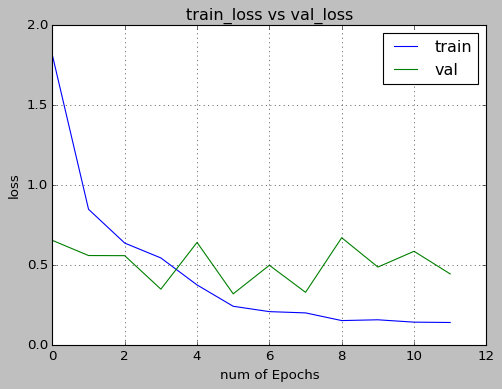

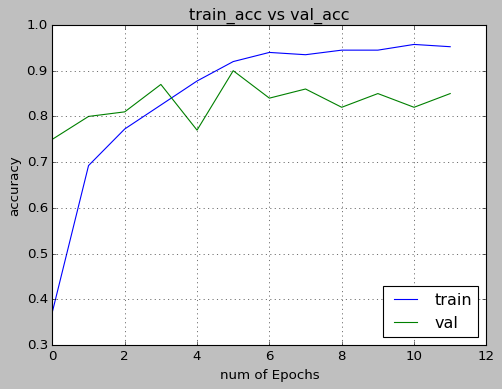

In [22]:
plt.figure(1, figsize=(7, 5))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train', 'val'])
plt.style.use(['classic'])

plt.figure(2, figsize=(7, 5))
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train', 'val'], loc=4)
plt.style.use(['classic'])
plt.show()

In [23]:
custom_resnet_model2.save_weights('FIC-ResNet-50-TL-Model.h5', overwrite=True)

## Prediction

In [25]:
from keras.applications.imagenet_utils import decode_predictions

Input image shape: (1, 224, 224, 3)
Image: 


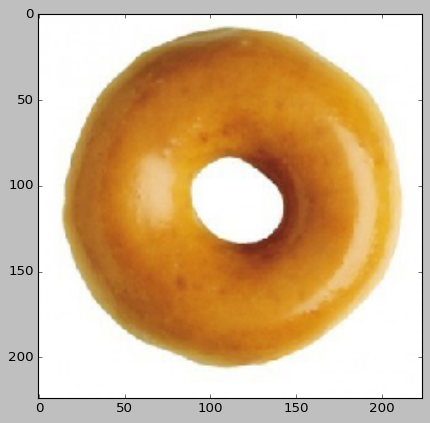


Prediction: 
apple-pie: 	5.305783474796044e-05 %
chocolate-cake: 	5.120719492879289e-05 %
donuts: 	99.99977350234985 %
french-toast: 	0.00012140253602410667 %
gnocchi: 	1.1130088495292512e-05 %


In [61]:
img_path = 'images/donut.jpg'
#img_path = 'images/chocolate_cake.jpg'
#img_path = 'images/apple_pie.jpg'
#img_path = 'images/gnocchi.jpg'
#img_path = 'images/french_toast.jpg'
img = image.load_img(img_path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = custom_resnet_model2.predict(x)

print('Image: ')
plt.imshow(img)
plt.show()

print('\nPrediction: ')
preds = preds[0]
for i in range(len(preds)):
    print(names[i] + ': \t{} %'.format(preds[i]*100))

In [ ]:
#img_path = 'images/donut.jpg'
img_path = 'images/chocolate_cake.jpg'
#img_path = 'images/apple_pie.jpg'
#img_path = 'images/gnocchi.jpg'
#img_path = 'images/french_toast.jpg'
img = image.load_img(img_path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = custom_resnet_model2.predict(x)

print('Image: ')
plt.imshow(img)
plt.show()

print('\nPrediction: ')
preds = preds[0]
for i in range(len(preds)):
    print(names[i] + ': \t{} %'.format(preds[i]*100))